<a href="https://colab.research.google.com/github/ErangaOttachchige/Final-Year-Research-Project/blob/main/03_inference_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Upload → Stage 1 filter → Stage 2 species → Final output

In [1]:
# Load models + label mappings (from Drive)

from google.colab import drive
drive.mount("/content/drive")

import os, json, torch
import timm
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T

DRIVE_CCT = "/content/drive/MyDrive/datasets/cct20"
PROC_DIR  = f"{DRIVE_CCT}/processed"

# --- paths (your saved files) ---
STAGE1_WEIGHTS = f"{PROC_DIR}/stage1_best_binary_efficientnet_b0.pt"
STAGE1_JSON    = f"{PROC_DIR}/stage1_binary_label_mapping.json"

STAGE2_WEIGHTS = f"{PROC_DIR}/stage2_best_species_efficientnet_b0_optimized.pt"
STAGE2_JSON    = f"{PROC_DIR}/stage2_label_mapping.json"

print("Stage1 weights:", os.path.exists(STAGE1_WEIGHTS))
print("Stage2 weights:", os.path.exists(STAGE2_WEIGHTS))
print("Stage1 json:", os.path.exists(STAGE1_JSON))
print("Stage2 json:", os.path.exists(STAGE2_JSON))

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# --- load label mappings ---
with open(STAGE1_JSON, "r") as f:
    m1 = json.load(f)
stage1_classes = m1["classes"]

with open(STAGE2_JSON, "r") as f:
    m2 = json.load(f)
stage2_classes = m2["classes"]

# --- build models ---
stage1_model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=len(stage1_classes)).to(device)
stage1_model.load_state_dict(torch.load(STAGE1_WEIGHTS, map_location=device))
stage1_model.eval()

stage2_model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=len(stage2_classes)).to(device)
stage2_model.load_state_dict(torch.load(STAGE2_WEIGHTS, map_location=device))
stage2_model.eval()

# input transform (must match training resize)
tf = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

print("✅ Models loaded.")
print("Stage1 classes:", stage1_classes)
print("Stage2 classes:", stage2_classes)


Mounted at /content/drive
Stage1 weights: True
Stage2 weights: True
Stage1 json: True
Stage2 json: True
Device: cpu
✅ Models loaded.
Stage1 classes: ['animal', 'non_animal']
Stage2 classes: ['bird', 'bobcat', 'cat', 'coyote', 'dog', 'opossum', 'other', 'rabbit', 'raccoon', 'rodent', 'skunk', 'squirrel']


Saving 2.jpg to 2.jpg
Uploaded: 2.jpg


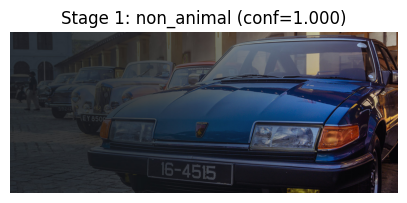

✅ FINAL: non_animal (conf=1.000)
Stage 2 skipped because Stage 1 says non-animal.


In [2]:
# Upload an image + run pipeline
from google.colab import files
import matplotlib.pyplot as plt

def predict_image(img_path: str):
    img = Image.open(img_path).convert("RGB")
    x = tf(img).unsqueeze(0).to(device)

    # ---- Stage 1: animal vs non_animal ----
    with torch.no_grad():
        logits1 = stage1_model(x)
        prob1 = F.softmax(logits1, dim=1)[0]
        pred1 = int(prob1.argmax().item())
        label1 = stage1_classes[pred1]
        conf1 = float(prob1[pred1].item())

    # show image
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Stage 1: {label1} (conf={conf1:.3f})")
    plt.show()

    # if not animal, stop here
    if label1 != "animal":
        print(f"✅ FINAL: {label1} (conf={conf1:.3f})")
        print("Stage 2 skipped because Stage 1 says non-animal.")
        return

    # ---- Stage 2: species ----
    with torch.no_grad():
        logits2 = stage2_model(x)
        prob2 = F.softmax(logits2, dim=1)[0]
        pred2 = int(prob2.argmax().item())
        label2 = stage2_classes[pred2]
        conf2 = float(prob2[pred2].item())

        # top-3 for nicer demo
        topk = torch.topk(prob2, k=3)
        top3 = [(stage2_classes[int(i)], float(v)) for v, i in zip(topk.values, topk.indices)]

    print(f"✅ FINAL: {label2} (conf={conf2:.3f})")
    print("Top-3 predictions:")
    for name, p in top3:
        print(f"  - {name:10s}  {p:.3f}")

# Upload
uploaded = files.upload()
img_path = next(iter(uploaded.keys()))
print("Uploaded:", img_path)

predict_image(img_path)
